# load in fruits dataset

In [ ]:
from google.colab import drive

# Mount Google Drive to access files and folders
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_FDs/training/'
val_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_FDs/validation/'
train_val_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_FDs/train_val'
test_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_FDs/test/'

# Download and import libraries

In [ ]:
!pip install timm
!pip install optuna
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np

from optuna.trial import TrialState
import optuna
import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

import imblearn.metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Create reproducible results

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


# Calculating pos weight

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weight train
train_dataset = ImageFolder(train_path)
train_targets = train_dataset.targets
train_class_counts = torch.bincount(torch.tensor(train_targets))

train_total_negative_samples = train_class_counts[0].item()
train_total_positive_samples = train_class_counts[1].item()

train_pos_weight = train_total_negative_samples / train_total_positive_samples

# Put class weight in tensor
train_pos_weight_tensor = torch.tensor(train_pos_weight)
train_pos_weight_tensor = train_pos_weight_tensor.to(DEVICE)
print(train_pos_weight_tensor)

tensor(0.8710, device='cuda:0')


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weight train_val dataset
train_val_dataset = ImageFolder(train_val_path)
train_val_targets = train_val_dataset.targets
train_val_class_counts = torch.bincount(torch.tensor(train_val_targets))

train_val_total_negative_samples = train_val_class_counts[0].item()
train_val_total_positive_samples = train_val_class_counts[1].item()

train_val_pos_weight = train_val_total_negative_samples / train_val_total_positive_samples

# Put class weight in tensor
train_val_pos_weight_tensor = torch.tensor(train_val_pos_weight)
train_val_pos_weight_tensor = train_val_pos_weight_tensor.to(DEVICE)
print(train_val_pos_weight_tensor)

tensor(0.8727, device='cuda:0')


# MaxViT model

In [ ]:
timm.list_models('*maxvit*', pretrained=True) # 'maxvit_tiny_tf_224.in1k', (resnet pretrained on imagenet 1k with input size 224x224)

['maxvit_base_tf_224.in1k',
 'maxvit_base_tf_224.in21k',
 'maxvit_base_tf_384.in1k',
 'maxvit_base_tf_384.in21k_ft_in1k',
 'maxvit_base_tf_512.in1k',
 'maxvit_base_tf_512.in21k_ft_in1k',
 'maxvit_large_tf_224.in1k',
 'maxvit_large_tf_224.in21k',
 'maxvit_large_tf_384.in1k',
 'maxvit_large_tf_384.in21k_ft_in1k',
 'maxvit_large_tf_512.in1k',
 'maxvit_large_tf_512.in21k_ft_in1k',
 'maxvit_nano_rw_256.sw_in1k',
 'maxvit_rmlp_base_rw_224.sw_in12k',
 'maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k',
 'maxvit_rmlp_base_rw_384.sw_in12k_ft_in1k',
 'maxvit_rmlp_nano_rw_256.sw_in1k',
 'maxvit_rmlp_pico_rw_256.sw_in1k',
 'maxvit_rmlp_small_rw_224.sw_in1k',
 'maxvit_rmlp_tiny_rw_256.sw_in1k',
 'maxvit_small_tf_224.in1k',
 'maxvit_small_tf_384.in1k',
 'maxvit_small_tf_512.in1k',
 'maxvit_tiny_rw_224.sw_in1k',
 'maxvit_tiny_tf_224.in1k',
 'maxvit_tiny_tf_384.in1k',
 'maxvit_tiny_tf_512.in1k',
 'maxvit_xlarge_tf_224.in21k',
 'maxvit_xlarge_tf_384.in21k_ft_in1k',
 'maxvit_xlarge_tf_512.in21k_ft_in1k']

## Do hyperparameter tuning MaxViT model

In [ ]:
# Set device and parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 32
epochs = 100


def define_model(trial):
  model = timm.create_model('maxvit_tiny_tf_224.in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.get_classifier().in_features

  head = []
  first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512, 768])
  head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
  head.append(nn.ReLU())
  drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
  head.append(nn.Dropout(p=drop_out))
  num_in_features = first_neuron

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_loader, valid_loader


def objective(trial):

  # Send model to the device
  model = define_model(trial).to(DEVICE)

  # Define optimizer and loss function
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weightdecay = trial.suggest_float("weightdecay", low=0.001, high=0.01, log=True)

  if optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weightdecay)


  use_pos_weight = trial.suggest_categorical("use_pos_weight", [True, False])

  if use_pos_weight is True:
    criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
  else:
    criterion = nn.BCEWithLogitsLoss()

  # Load in dataset
  train_loader, valid_loader = get_dataset()

  # Initialize variables for early stopping
  best_loss = 1000000
  patience = 5
  no_improvement_count = 0


  # Training
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    y_true = []
    y_pred = []


    for i in train_loader:
        #LOADING THE DATA IN A BATCH
        data, target = i

        # moving the tensors to the configured device
        data, target = data.to(DEVICE), target.to(DEVICE)

        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))

        train_loss += loss.item() * data.size(0)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #PREDICTIONS BCELogitsloss()
        pred = torch.round(torch.sigmoid(output.detach()))
        y_true.extend(target.tolist())
        y_pred.extend(pred.reshape(-1).tolist())

    train_loss /= len(train_loader.sampler)
    train_accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    train_specificity = tn / (tn + fp)
    train_sensitivity = tp / (tp + fn)

    train_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


    # Evaluation:

    #model in eval mode skips Dropout etc
    model.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in valid_loader:

            #LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(DEVICE), target.to(DEVICE)

            target = target.float()
            output = model(data.float())

            loss = criterion(output, target.unsqueeze(1))
            valid_loss += loss.item() * data.size(0)


            #PREDICTIONS
            pred = torch.round(torch.sigmoid(output))
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    valid_loss /= len(valid_loader.sampler)
    valid_accuracy = accuracy_score(y_true,y_pred)

    # get the specificity, sensitivity and g-mean
    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    valid_specificity = tn / (tn + fp)
    valid_sensitivity = tp / (tp + fn)

    valid_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}% "
          f"Train specificity: {train_specificity:.4f}, Train sensitivity: {train_sensitivity:.4f} Train g_mean: {train_gmean:.4f}% ----> "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f} %"
          f"Valid specificity: {valid_specificity:.4f}, Valid sensitivity: {valid_sensitivity:.4f} Valid g_mean: {valid_gmean:.4f}")

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping criterion met at epoch {}".format(epoch))
        break

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Report the intermediate result
    trial.report(valid_gmean, epoch)

  return valid_gmean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-06-13 10:09:49,443] A new study created in memory with name: no-name-9a11f8fe-a190-4d4a-95b2-f0acdc8ddb91


Epoch [1/100], Train Loss: 9.4974, Train Accuracy: 0.4310% Train specificity: 0.3148, Train sensitivity: 0.5323 Train g_mean: 0.4093% ----> Valid Loss: 1.0947, Valid Accuracy: 0.3051 %Valid specificity: 0.9444, Valid sensitivity: 0.0244 Valid g_mean: 0.1518
Epoch [2/100], Train Loss: 0.8036, Train Accuracy: 0.5733% Train specificity: 0.5370, Train sensitivity: 0.6048 Train g_mean: 0.5699% ----> Valid Loss: 0.9495, Valid Accuracy: 0.3390 %Valid specificity: 0.9444, Valid sensitivity: 0.0732 Valid g_mean: 0.2629
Epoch [3/100], Train Loss: 0.5821, Train Accuracy: 0.7026% Train specificity: 0.7037, Train sensitivity: 0.7016 Train g_mean: 0.7027% ----> Valid Loss: 1.3866, Valid Accuracy: 0.3390 %Valid specificity: 0.8889, Valid sensitivity: 0.0976 Valid g_mean: 0.2945
Epoch [4/100], Train Loss: 0.5313, Train Accuracy: 0.7457% Train specificity: 0.8611, Train sensitivity: 0.6452 Train g_mean: 0.7454% ----> Valid Loss: 0.7560, Valid Accuracy: 0.7288 %Valid specificity: 0.1111, Valid sensitivi

[I 2023-06-13 10:38:19,534] Trial 0 finished with value: 0.690626360377083 and parameters: {'first_neuron': 768, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.002459135488146956, 'weightdecay': 0.0022035846933948565, 'use_pos_weight': False}. Best is trial 0 with value: 0.690626360377083.


Epoch [18/100], Train Loss: 0.2269, Train Accuracy: 0.9267% Train specificity: 0.9167, Train sensitivity: 0.9355 Train g_mean: 0.9260% ----> Valid Loss: 0.5728, Valid Accuracy: 0.6441 %Valid specificity: 0.8889, Valid sensitivity: 0.5366 Valid g_mean: 0.6906
Early stopping criterion met at epoch 17
Epoch [1/100], Train Loss: 0.5769, Train Accuracy: 0.6853% Train specificity: 0.7222, Train sensitivity: 0.6532 Train g_mean: 0.6869% ----> Valid Loss: 0.5997, Valid Accuracy: 0.5254 %Valid specificity: 0.5000, Valid sensitivity: 0.5366 Valid g_mean: 0.5180
Epoch [2/100], Train Loss: 0.4009, Train Accuracy: 0.8448% Train specificity: 0.8056, Train sensitivity: 0.8790 Train g_mean: 0.8415% ----> Valid Loss: 0.6172, Valid Accuracy: 0.5593 %Valid specificity: 0.5556, Valid sensitivity: 0.5610 Valid g_mean: 0.5583
Epoch [3/100], Train Loss: 0.3116, Train Accuracy: 0.8621% Train specificity: 0.9352, Train sensitivity: 0.7984 Train g_mean: 0.8641% ----> Valid Loss: 0.5889, Valid Accuracy: 0.7966 %

[I 2023-06-13 11:10:42,269] Trial 1 finished with value: 0.8312983282607428 and parameters: {'first_neuron': 768, 'drop_out': 0.3, 'optimizer': 'AdamW', 'lr': 0.001065392634962061, 'weightdecay': 0.0022100837408573753, 'use_pos_weight': True}. Best is trial 1 with value: 0.8312983282607428.


Epoch [21/100], Train Loss: 0.1530, Train Accuracy: 0.9483% Train specificity: 0.9352, Train sensitivity: 0.9597 Train g_mean: 0.9474% ----> Valid Loss: 0.4249, Valid Accuracy: 0.8305 %Valid specificity: 0.8333, Valid sensitivity: 0.8293 Valid g_mean: 0.8313
Early stopping criterion met at epoch 20
Epoch [1/100], Train Loss: 0.6887, Train Accuracy: 0.5388% Train specificity: 0.0370, Train sensitivity: 0.9758 Train g_mean: 0.1901% ----> Valid Loss: 0.6445, Valid Accuracy: 0.7458 %Valid specificity: 0.2222, Valid sensitivity: 0.9756 Valid g_mean: 0.4656
Epoch [2/100], Train Loss: 0.6137, Train Accuracy: 0.7888% Train specificity: 0.7593, Train sensitivity: 0.8145 Train g_mean: 0.7864% ----> Valid Loss: 0.6679, Valid Accuracy: 0.5085 %Valid specificity: 0.6111, Valid sensitivity: 0.4634 Valid g_mean: 0.5322
Epoch [3/100], Train Loss: 0.5594, Train Accuracy: 0.8017% Train specificity: 0.8241, Train sensitivity: 0.7823 Train g_mean: 0.8029% ----> Valid Loss: 0.5793, Valid Accuracy: 0.7627 %

[I 2023-06-13 11:43:02,448] Trial 2 finished with value: 0.7080642721887156 and parameters: {'first_neuron': 256, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.00035565758620295277, 'weightdecay': 0.001597763898219447, 'use_pos_weight': False}. Best is trial 1 with value: 0.8312983282607428.


Epoch [21/100], Train Loss: 0.1600, Train Accuracy: 0.9483% Train specificity: 0.9167, Train sensitivity: 0.9758 Train g_mean: 0.9458% ----> Valid Loss: 0.4935, Valid Accuracy: 0.7966 %Valid specificity: 0.5556, Valid sensitivity: 0.9024 Valid g_mean: 0.7081
Early stopping criterion met at epoch 20
Epoch [1/100], Train Loss: 1.1067, Train Accuracy: 0.5474% Train specificity: 0.5185, Train sensitivity: 0.5726 Train g_mean: 0.5449% ----> Valid Loss: 1.8574, Valid Accuracy: 0.3051 %Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.7359, Train Accuracy: 0.6724% Train specificity: 0.7407, Train sensitivity: 0.6129 Train g_mean: 0.6738% ----> Valid Loss: 1.0087, Valid Accuracy: 0.6949 %Valid specificity: 0.1667, Valid sensitivity: 0.9268 Valid g_mean: 0.3930
Epoch [3/100], Train Loss: 0.3988, Train Accuracy: 0.8147% Train specificity: 0.8241, Train sensitivity: 0.8065 Train g_mean: 0.8152% ----> Valid Loss: 0.6190, Valid Accuracy: 0.6102 %

[I 2023-06-13 12:02:56,092] Trial 3 finished with value: 0.6636108828176629 and parameters: {'first_neuron': 768, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.008215596022181977, 'weightdecay': 0.0024344223929353894, 'use_pos_weight': False}. Best is trial 1 with value: 0.8312983282607428.


Epoch [13/100], Train Loss: 0.2520, Train Accuracy: 0.9009% Train specificity: 0.8519, Train sensitivity: 0.9435 Train g_mean: 0.8965% ----> Valid Loss: 0.8459, Valid Accuracy: 0.6441 %Valid specificity: 0.7222, Valid sensitivity: 0.6098 Valid g_mean: 0.6636
Early stopping criterion met at epoch 12
Epoch [1/100], Train Loss: 0.6360, Train Accuracy: 0.5431% Train specificity: 0.7222, Train sensitivity: 0.3871 Train g_mean: 0.5287% ----> Valid Loss: 0.6369, Valid Accuracy: 0.3898 %Valid specificity: 0.9444, Valid sensitivity: 0.1463 Valid g_mean: 0.3718
Epoch [2/100], Train Loss: 0.5868, Train Accuracy: 0.7586% Train specificity: 0.7870, Train sensitivity: 0.7339 Train g_mean: 0.7600% ----> Valid Loss: 0.6049, Valid Accuracy: 0.6610 %Valid specificity: 0.5556, Valid sensitivity: 0.7073 Valid g_mean: 0.6269
Epoch [3/100], Train Loss: 0.5469, Train Accuracy: 0.7845% Train specificity: 0.8519, Train sensitivity: 0.7258 Train g_mean: 0.7863% ----> Valid Loss: 0.5958, Valid Accuracy: 0.6271 %

[I 2023-06-13 12:28:51,741] Trial 4 finished with value: 0.6584863977663931 and parameters: {'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.00029102921730457147, 'weightdecay': 0.001822540185850077, 'use_pos_weight': True}. Best is trial 1 with value: 0.8312983282607428.


Epoch [17/100], Train Loss: 0.1701, Train Accuracy: 0.9310% Train specificity: 0.9167, Train sensitivity: 0.9435 Train g_mean: 0.9300% ----> Valid Loss: 0.4584, Valid Accuracy: 0.8136 %Valid specificity: 0.4444, Valid sensitivity: 0.9756 Valid g_mean: 0.6585
Early stopping criterion met at epoch 16
Epoch [1/100], Train Loss: 0.6236, Train Accuracy: 0.6078% Train specificity: 0.5648, Train sensitivity: 0.6452 Train g_mean: 0.6037% ----> Valid Loss: 0.5951, Valid Accuracy: 0.6949 %Valid specificity: 0.3333, Valid sensitivity: 0.8537 Valid g_mean: 0.5334
Epoch [2/100], Train Loss: 0.4247, Train Accuracy: 0.8233% Train specificity: 0.7963, Train sensitivity: 0.8468 Train g_mean: 0.8211% ----> Valid Loss: 0.5209, Valid Accuracy: 0.7627 %Valid specificity: 0.3889, Valid sensitivity: 0.9268 Valid g_mean: 0.6004
Epoch [3/100], Train Loss: 0.3080, Train Accuracy: 0.8879% Train specificity: 0.8889, Train sensitivity: 0.8871 Train g_mean: 0.8880% ----> Valid Loss: 0.4474, Valid Accuracy: 0.7966 %

[I 2023-06-13 12:41:24,301] Trial 5 finished with value: 0.6797496749511588 and parameters: {'first_neuron': 768, 'drop_out': 0.5, 'optimizer': 'AdamW', 'lr': 0.0011851423723102036, 'weightdecay': 0.004330877653098145, 'use_pos_weight': False}. Best is trial 1 with value: 0.8312983282607428.


Epoch [8/100], Train Loss: 0.2622, Train Accuracy: 0.8922% Train specificity: 0.8796, Train sensitivity: 0.9032 Train g_mean: 0.8913% ----> Valid Loss: 0.4733, Valid Accuracy: 0.7119 %Valid specificity: 0.6111, Valid sensitivity: 0.7561 Valid g_mean: 0.6797
Early stopping criterion met at epoch 7
Epoch [1/100], Train Loss: 0.6407, Train Accuracy: 0.4957% Train specificity: 0.8889, Train sensitivity: 0.1532 Train g_mean: 0.3691% ----> Valid Loss: 0.5830, Valid Accuracy: 0.7797 %Valid specificity: 0.4444, Valid sensitivity: 0.9268 Valid g_mean: 0.6418
Epoch [2/100], Train Loss: 0.5302, Train Accuracy: 0.7974% Train specificity: 0.6667, Train sensitivity: 0.9113 Train g_mean: 0.7794% ----> Valid Loss: 0.5922, Valid Accuracy: 0.5763 %Valid specificity: 0.6111, Valid sensitivity: 0.5610 Valid g_mean: 0.5855
Epoch [3/100], Train Loss: 0.4632, Train Accuracy: 0.7716% Train specificity: 0.9352, Train sensitivity: 0.6290 Train g_mean: 0.7670% ----> Valid Loss: 0.5246, Valid Accuracy: 0.7119 %Va

[I 2023-06-13 13:07:36,812] Trial 6 finished with value: 0.6896446592974972 and parameters: {'first_neuron': 512, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.0007380578450339056, 'weightdecay': 0.005457323860950466, 'use_pos_weight': True}. Best is trial 1 with value: 0.8312983282607428.


Epoch [17/100], Train Loss: 0.2033, Train Accuracy: 0.9095% Train specificity: 0.8981, Train sensitivity: 0.9194 Train g_mean: 0.9087% ----> Valid Loss: 0.6275, Valid Accuracy: 0.6780 %Valid specificity: 0.7222, Valid sensitivity: 0.6585 Valid g_mean: 0.6896
Early stopping criterion met at epoch 16
Epoch [1/100], Train Loss: 1.3040, Train Accuracy: 0.5517% Train specificity: 0.5185, Train sensitivity: 0.5806 Train g_mean: 0.5487% ----> Valid Loss: 0.6767, Valid Accuracy: 0.4746 %Valid specificity: 0.6111, Valid sensitivity: 0.4146 Valid g_mean: 0.5034
Epoch [2/100], Train Loss: 0.4995, Train Accuracy: 0.7586% Train specificity: 0.7315, Train sensitivity: 0.7823 Train g_mean: 0.7564% ----> Valid Loss: 0.5729, Valid Accuracy: 0.7458 %Valid specificity: 0.1667, Valid sensitivity: 1.0000 Valid g_mean: 0.4082


[I 2023-06-13 13:12:19,591] Trial 7 pruned. 


Epoch [3/100], Train Loss: 0.4253, Train Accuracy: 0.8147% Train specificity: 0.7778, Train sensitivity: 0.8468 Train g_mean: 0.8115% ----> Valid Loss: 0.7455, Valid Accuracy: 0.5085 %Valid specificity: 0.5556, Valid sensitivity: 0.4878 Valid g_mean: 0.5206
Epoch [1/100], Train Loss: 0.6291, Train Accuracy: 0.6293% Train specificity: 0.5556, Train sensitivity: 0.6935 Train g_mean: 0.6207% ----> Valid Loss: 0.5734, Valid Accuracy: 0.6949 %Valid specificity: 0.2222, Valid sensitivity: 0.9024 Valid g_mean: 0.4478


[I 2023-06-13 13:15:28,310] Trial 8 pruned. 


Epoch [2/100], Train Loss: 0.3395, Train Accuracy: 0.8707% Train specificity: 0.8611, Train sensitivity: 0.8790 Train g_mean: 0.8700% ----> Valid Loss: 0.6271, Valid Accuracy: 0.6780 %Valid specificity: 0.6111, Valid sensitivity: 0.7073 Valid g_mean: 0.6575
Epoch [1/100], Train Loss: 0.6637, Train Accuracy: 0.6422% Train specificity: 0.7685, Train sensitivity: 0.5323 Train g_mean: 0.6396% ----> Valid Loss: 0.5717, Valid Accuracy: 0.6610 %Valid specificity: 0.1667, Valid sensitivity: 0.8780 Valid g_mean: 0.3825


[I 2023-06-13 13:18:32,568] Trial 9 pruned. 


Epoch [2/100], Train Loss: 0.5142, Train Accuracy: 0.7069% Train specificity: 0.7315, Train sensitivity: 0.6855 Train g_mean: 0.7081% ----> Valid Loss: 0.5669, Valid Accuracy: 0.7458 %Valid specificity: 0.1667, Valid sensitivity: 1.0000 Valid g_mean: 0.4082
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  3
  Number of complete trials:  7
Best trial:
  Value:  0.8312983282607428
  Params: 
    first_neuron: 768
    drop_out: 0.3
    optimizer: AdamW
    lr: 0.001065392634962061
    weightdecay: 0.0022100837408573753
    use_pos_weight: True


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_lr,params_optimizer,params_use_pos_weight,params_weightdecay,state
0,0,0.690626,2023-06-13 10:09:49.446241,2023-06-13 10:38:19.533399,0 days 00:28:30.087158,0.3,768,0.002459,RMSprop,False,0.002204,COMPLETE
1,1,0.831298,2023-06-13 10:38:19.539201,2023-06-13 11:10:42.269311,0 days 00:32:22.730110,0.3,768,0.001065,AdamW,True,0.002210,COMPLETE
2,2,0.708064,2023-06-13 11:10:42.271157,2023-06-13 11:43:02.447606,0 days 00:32:20.176449,0.0,256,0.000356,Adam,False,0.001598,COMPLETE
3,3,0.663611,2023-06-13 11:43:02.451445,2023-06-13 12:02:56.092056,0 days 00:19:53.640611,0.3,768,0.008216,Adam,False,0.002434,COMPLETE
4,4,0.658486,2023-06-13 12:02:56.093646,2023-06-13 12:28:51.740390,0 days 00:25:55.646744,0.3,256,0.000291,Adam,True,0.001823,COMPLETE
5,5,0.679750,2023-06-13 12:28:51.745820,2023-06-13 12:41:24.301083,0 days 00:12:32.555263,0.5,768,0.001185,AdamW,False,0.004331,COMPLETE
6,6,0.689645,2023-06-13 12:41:24.302836,2023-06-13 13:07:36.811540,0 days 00:26:12.508704,0.5,512,0.000738,Adam,True,0.005457,COMPLETE
7,7,0.408248,2023-06-13 13:07:36.818502,2023-06-13 13:12:19.590971,0 days 00:04:42.772469,0.5,768,0.000828,RMSprop,False,0.002152,PRUNED
8,8,0.447819,2023-06-13 13:12:19.592787,2023-06-13 13:15:28.309851,0 days 00:03:08.717064,0.0,256,0.002157,AdamW,False,0.002612,PRUNED
9,9,0.382546,2023-06-13 13:15:28.311368,2023-06-13 13:18:32.568783,0 days 00:03:04.257415,0.3,768,0.000423,RMSprop,True,0.001335,PRUNED


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

## Train the MaxViT model with the best hyperparameters (on combined training and validation dataset)

In [ ]:
BATCHSIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_neurons = 768
best_dropout = 0.3
best_optimizer = 'AdamW'
best_lr = 0.001065
epochs = 21
weight_decay = 0.002210
use_pos_weight = True



def define_model():
  model = timm.create_model('maxvit_tiny_tf_224.in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False


  num_in_features = model.get_classifier().in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
  head.append(nn.ReLU())
  head.append(nn.Dropout(p=best_dropout))
  num_in_features = best_neurons

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid) # Test dataset only used to see learning curve (no hp tuning)

  train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_val_loader, test_loader


# Send model to the device
model = define_model().to(DEVICE)

# Define optimizer and loss function
if best_optimizer == 'RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'AdamW':
  optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=weight_decay)

if use_pos_weight is True:
  criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
else:
  criterion = nn.BCEWithLogitsLoss()

# Load in dataset
train_val_loader, test_loader = get_dataset()

# Initialize variables for early stopping
best_loss = 1000000
patience = 5
no_improvement_count = 0

# train_val
train_val_losses = []
train_val_accuracies = []
test_losses = []
test_accuracies = []

# Training
for epoch in range(epochs):
  model.train()
  train_val_loss = 0.0
  y_true = []
  y_pred = []


  for i in train_val_loader:
      #LOADING THE DATA IN A BATCH
      data, target = i

      # moving the tensors to the configured device
      data, target = data.to(DEVICE), target.to(DEVICE)

      #FORWARD PASS
      target = target.float()
      output = model(data.float())
      loss = criterion(output, target.unsqueeze(1))

      train_val_loss += loss.item() * data.size(0)

      #BACKWARD AND OPTIMIZE
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #PREDICTIONS BCELogitsloss()
      pred = torch.round(torch.sigmoid(output.detach()))
      y_true.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  train_val_loss /= len(train_val_loader.sampler)
  train_val_accuracy = accuracy_score(y_true, y_pred)

  train_val_losses.append(train_val_loss)
  train_val_accuracies.append(train_val_accuracy)

  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  train_val_specificity = tn / (tn + fp)
  train_val_sensitivity = tp / (tp + fn)

  train_val_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  # Evaluation:

   #model in eval mode skips Dropout etc
  model.eval()
  test_loss = 0.0
  y_true = []
  y_pred = []

  # set the requires_grad flag to false as we are in the test mode
  with torch.no_grad():
      for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred = torch.round(torch.sigmoid(output))
          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())

  test_loss /= len(test_loader.sampler)
  test_accuracy = accuracy_score(y_true, y_pred)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # get the specificity, sensitivity and g-mean
  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  test_specificity = tn / (tn + fp)
  test_sensitivity = tp / (tp + fn)

  test_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  print(f"Epoch [{epoch+1}/{epochs}], Train_val Loss: {train_val_loss:.4f}, Train_val Accuracy: {train_val_accuracy:.4f}%, "
        f"Train_val specificity: {train_val_specificity:.4f}, Train_val sensitivity: {train_val_sensitivity:.4f}, Train_val g_mean: {train_val_gmean:.4f}% ----> "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%, "
        f"Test specificity: {test_specificity:.4f}, Test sensitivity: {test_sensitivity:.4f}, Test g_mean: {test_gmean:.4f}")

Epoch [1/21], Train_val Loss: 0.5741, Train_val Accuracy: 0.6472%, Train_val specificity: 0.6806, Train_val sensitivity: 0.6182, Train_val g_mean: 0.6486% ----> Test Loss: 0.5713, Test Accuracy: 0.6167%, Test specificity: 0.9444, Test sensitivity: 0.4762, Test g_mean: 0.6706
Epoch [2/21], Train_val Loss: 0.4297, Train_val Accuracy: 0.7670%, Train_val specificity: 0.8264, Train_val sensitivity: 0.7152, Train_val g_mean: 0.7688% ----> Test Loss: 0.4175, Test Accuracy: 0.7667%, Test specificity: 0.9444, Test sensitivity: 0.6905, Test g_mean: 0.8075
Epoch [3/21], Train_val Loss: 0.3303, Train_val Accuracy: 0.8414%, Train_val specificity: 0.8264, Train_val sensitivity: 0.8545, Train_val g_mean: 0.8403% ----> Test Loss: 0.3390, Test Accuracy: 0.8667%, Test specificity: 0.7222, Test sensitivity: 0.9286, Test g_mean: 0.8189
Epoch [4/21], Train_val Loss: 0.2532, Train_val Accuracy: 0.8997%, Train_val specificity: 0.8958, Train_val sensitivity: 0.9030, Train_val g_mean: 0.8994% ----> Test Loss: 

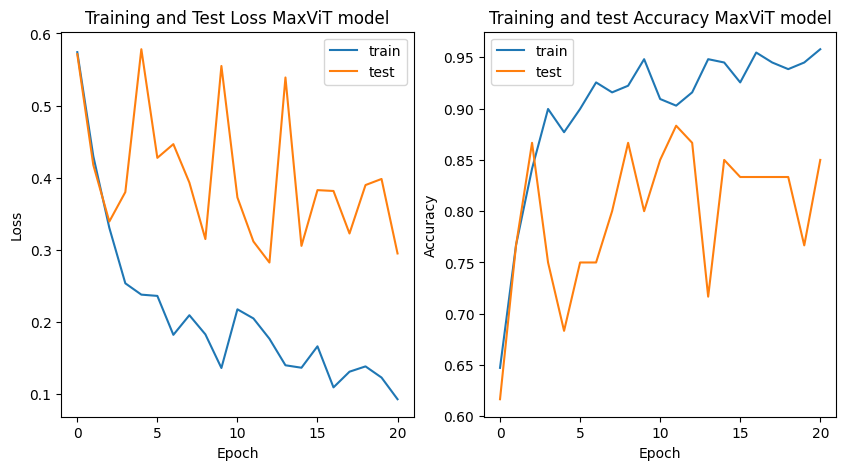

In [ ]:
# Plot the validation and training loss and accuracy values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_val_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss MaxViT model')
ax[0].legend()
ax[1].plot(train_val_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy MaxViT model')
ax[1].legend()
plt.show()

## Test performance MaxViT model

In [ ]:
# load in testset
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
model.eval()
test_loss = 0.0
y_true = []
y_pred = []
Y_pred_prob = []

with torch.no_grad():
   for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred_prop = torch.sigmoid(output)
          pred = torch.round(torch.sigmoid(output))

          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())
          Y_pred_prob.extend(pred_prop.reshape(-1).tolist())

test_loss /= len(test_loader.sampler)
test_accuracy = accuracy_score(y_true,y_pred)

# get the specificity, sensitivity and g-mean
cm = confusion_matrix(y_true, y_pred)

# Extract the elements of the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

g_mean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


print()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, Y_pred_prob)

# Print the evaluation metrics
print('Test_loss:', test_loss)
print('Accuracy:', test_accuracy)
print()

print('Specificity:', specificity)
print('Sensitivity:', sensitivity)
print('g_mean:', g_mean)
print()

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))


Test_loss: 0.29465424418449404
Accuracy: 0.85

Specificity: 0.8888888888888888
Sensitivity: 0.8333333333333334
g_mean: 0.8606629658238704

Precision: 0.9459459459459459
Recall: 0.8333333333333334
F1-score: 0.8860759493670887
F1_score_macro: 0.8332818771225687
AUC-ROC: 0.9365079365079365

              precision    recall  f1-score   support

         0.0       0.70      0.89      0.78        18
         1.0       0.95      0.83      0.89        42

    accuracy                           0.85        60
   macro avg       0.82      0.86      0.83        60
weighted avg       0.87      0.85      0.85        60



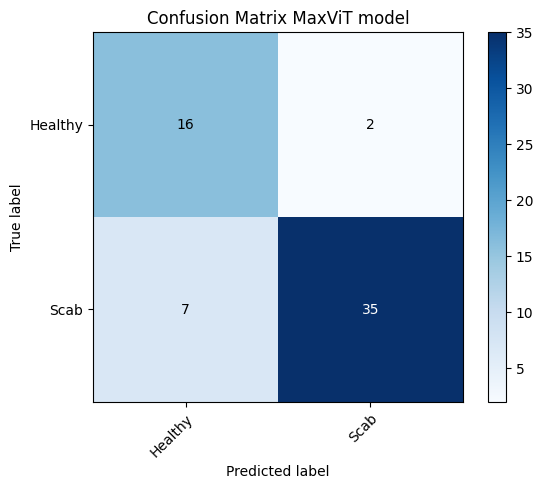

In [ ]:
import matplotlib.pyplot as plt

# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix MaxViT model")
plt.show()

# Swin transformer model

In [ ]:
timm.list_models('*swin*', pretrained=True)
# 'swin_tiny_patch4_window7_224.ms_in1k', (swin_tiny_patch4_window7_224 pretrained on imagenet 1k with input size 224x224)

['swin_base_patch4_window7_224.ms_in1k',
 'swin_base_patch4_window7_224.ms_in22k',
 'swin_base_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_base_patch4_window12_384.ms_in1k',
 'swin_base_patch4_window12_384.ms_in22k',
 'swin_base_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_large_patch4_window7_224.ms_in22k',
 'swin_large_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_large_patch4_window12_384.ms_in22k',
 'swin_large_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_s3_base_224.ms_in1k',
 'swin_s3_small_224.ms_in1k',
 'swin_s3_tiny_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in22k',
 'swin_small_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_tiny_patch4_window7_224.ms_in1k',
 'swin_tiny_patch4_window7_224.ms_in22k',
 'swin_tiny_patch4_window7_224.ms_in22k_ft_in1k',
 'swinv2_base_window8_256.ms_in1k',
 'swinv2_base_window12_192.ms_in22k',
 'swinv2_base_window12to16_192to256.ms_in22k_ft_in1k',
 'swinv2_base_window12to24_192to384.ms_in22k_ft_in1k',


## Do hyperparameter tuning Swin transformer model

In [ ]:
# Set device and parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 32
epochs = 100


def define_model(trial):
  model = timm.create_model('swin_tiny_patch4_window7_224.ms_in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.get_classifier().in_features

  head = []
  first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512, 768])
  head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
  head.append(nn.ReLU())
  drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
  head.append(nn.Dropout(p=drop_out))
  num_in_features = first_neuron

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)

  return train_loader, valid_loader


def objective(trial):

  # Send model to the device
  model = define_model(trial).to(DEVICE)

  # Define optimizer and loss function
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weightdecay = trial.suggest_float("weightdecay", low=0.001, high=0.01, log=True)

  if optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weightdecay)


  use_pos_weight = trial.suggest_categorical("use_pos_weight", [True, False])

  if use_pos_weight is True:
    criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
  else:
    criterion = nn.BCEWithLogitsLoss()

  # Load in dataset
  train_loader, valid_loader = get_dataset()

  # Initialize variables for early stopping
  best_loss = 1000000
  patience = 5
  no_improvement_count = 0


  # Training
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    y_true = []
    y_pred = []


    for i in train_loader:
        #LOADING THE DATA IN A BATCH
        data, target = i

        # moving the tensors to the configured device
        data, target = data.to(DEVICE), target.to(DEVICE)

        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))

        train_loss += loss.item() * data.size(0)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #PREDICTIONS BCELogitsloss()
        pred = torch.round(torch.sigmoid(output.detach()))
        y_true.extend(target.tolist())
        y_pred.extend(pred.reshape(-1).tolist())

    train_loss /= len(train_loader.sampler)
    train_accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    train_specificity = tn / (tn + fp)
    train_sensitivity = tp / (tp + fn)

    train_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


    # Evaluation:

    #model in eval mode skips Dropout etc
    model.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in valid_loader:

            #LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(DEVICE), target.to(DEVICE)

            target = target.float()
            output = model(data.float())

            loss = criterion(output, target.unsqueeze(1))
            valid_loss += loss.item() * data.size(0)


            #PREDICTIONS
            pred = torch.round(torch.sigmoid(output))
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    valid_loss /= len(valid_loader.sampler)
    valid_accuracy = accuracy_score(y_true,y_pred)

    # get the specificity, sensitivity and g-mean
    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    valid_specificity = tn / (tn + fp)
    valid_sensitivity = tp / (tp + fn)

    valid_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}% "
          f"Train specificity: {train_specificity:.4f}, Train sensitivity: {train_sensitivity:.4f} Train g_mean: {train_gmean:.4f}% ----> "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}% "
          f"Valid specificity: {valid_specificity:.4f}, Valid sensitivity: {valid_sensitivity:.4f} Valid g_mean: {valid_gmean:.4f}")

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping criterion met at epoch {}".format(epoch))
        break

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Report the intermediate result
    trial.report(valid_gmean, epoch)

  return valid_gmean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-06-13 14:34:19,523] A new study created in memory with name: no-name-83133cdd-a837-4daf-ba7a-7281712f2d5f
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)



Epoch [1/100], Train Loss: 0.6812, Train Accuracy: 0.6078% Train specificity: 0.4352, Train sensitivity: 0.7581 Train g_mean: 0.5744% ----> Valid Loss: 0.7246, Valid Accuracy: 0.3051% Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6433, Train Accuracy: 0.6250% Train specificity: 0.5185, Train sensitivity: 0.7177 Train g_mean: 0.6101% ----> Valid Loss: 0.6596, Valid Accuracy: 0.6102% Valid specificity: 0.8889, Valid sensitivity: 0.4878 Valid g_mean: 0.6585
Epoch [3/100], Train Loss: 0.6030, Train Accuracy: 0.7586% Train specificity: 0.6667, Train sensitivity: 0.8387 Train g_mean: 0.7478% ----> Valid Loss: 0.6518, Valid Accuracy: 0.6271% Valid specificity: 0.8889, Valid sensitivity: 0.5122 Valid g_mean: 0.6747
Epoch [4/100], Train Loss: 0.5782, Train Accuracy: 0.7931% Train specificity: 0.8241, Train sensitivity: 0.7661 Train g_mean: 0.7946% ----> Valid Loss: 0.5879, Valid Accuracy: 0.7966% Valid specificity: 0.3889, Valid sensitivi

[I 2023-06-13 15:36:05,775] Trial 0 finished with value: 0.8189821166039423 and parameters: {'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.00010111286094472554, 'weightdecay': 0.002197581263920083, 'use_pos_weight': False}. Best is trial 0 with value: 0.8189821166039423.


Epoch [44/100], Train Loss: 0.3004, Train Accuracy: 0.8966% Train specificity: 0.9074, Train sensitivity: 0.8871 Train g_mean: 0.8972% ----> Valid Loss: 0.4385, Valid Accuracy: 0.8136% Valid specificity: 0.8333, Valid sensitivity: 0.8049 Valid g_mean: 0.8190
Early stopping criterion met at epoch 43
Epoch [1/100], Train Loss: 0.6359, Train Accuracy: 0.6034% Train specificity: 0.6759, Train sensitivity: 0.5403 Train g_mean: 0.6043% ----> Valid Loss: 0.6289, Valid Accuracy: 0.4237% Valid specificity: 0.8333, Valid sensitivity: 0.2439 Valid g_mean: 0.4508
Epoch [2/100], Train Loss: 0.6022, Train Accuracy: 0.7414% Train specificity: 0.8796, Train sensitivity: 0.6210 Train g_mean: 0.7391% ----> Valid Loss: 0.6191, Valid Accuracy: 0.5254% Valid specificity: 0.7778, Valid sensitivity: 0.4146 Valid g_mean: 0.5679
Epoch [3/100], Train Loss: 0.5876, Train Accuracy: 0.6897% Train specificity: 0.9259, Train sensitivity: 0.4839 Train g_mean: 0.6693% ----> Valid Loss: 0.6031, Valid Accuracy: 0.6610% 

[I 2023-06-13 16:34:44,510] Trial 1 finished with value: 0.8553989227683015 and parameters: {'first_neuron': 768, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.00010193500705248972, 'weightdecay': 0.001949919656496065, 'use_pos_weight': True}. Best is trial 1 with value: 0.8553989227683015.


Epoch [41/100], Train Loss: 0.2013, Train Accuracy: 0.9310% Train specificity: 0.9259, Train sensitivity: 0.9355 Train g_mean: 0.9307% ----> Valid Loss: 0.3190, Valid Accuracy: 0.8644% Valid specificity: 0.8333, Valid sensitivity: 0.8780 Valid g_mean: 0.8554
Early stopping criterion met at epoch 40
Epoch [1/100], Train Loss: 0.6273, Train Accuracy: 0.5862% Train specificity: 0.4630, Train sensitivity: 0.6935 Train g_mean: 0.5666% ----> Valid Loss: 0.6193, Valid Accuracy: 0.5085% Valid specificity: 0.7778, Valid sensitivity: 0.3902 Valid g_mean: 0.5509
Epoch [2/100], Train Loss: 0.5561, Train Accuracy: 0.7328% Train specificity: 0.7963, Train sensitivity: 0.6774 Train g_mean: 0.7345% ----> Valid Loss: 0.5234, Valid Accuracy: 0.7797% Valid specificity: 0.3333, Valid sensitivity: 0.9756 Valid g_mean: 0.5703
Epoch [3/100], Train Loss: 0.4965, Train Accuracy: 0.7759% Train specificity: 0.7037, Train sensitivity: 0.8387 Train g_mean: 0.7682% ----> Valid Loss: 0.5597, Valid Accuracy: 0.7119% 

[I 2023-06-13 17:15:07,307] Trial 2 finished with value: 0.8490389912554587 and parameters: {'first_neuron': 256, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.0005696526853342621, 'weightdecay': 0.001762352615438204, 'use_pos_weight': True}. Best is trial 1 with value: 0.8553989227683015.


Epoch [28/100], Train Loss: 0.1169, Train Accuracy: 0.9526% Train specificity: 0.9444, Train sensitivity: 0.9597 Train g_mean: 0.9520% ----> Valid Loss: 0.2639, Valid Accuracy: 0.8814% Valid specificity: 0.7778, Valid sensitivity: 0.9268 Valid g_mean: 0.8490
Early stopping criterion met at epoch 27
Epoch [1/100], Train Loss: 0.5984, Train Accuracy: 0.5991% Train specificity: 0.6389, Train sensitivity: 0.5645 Train g_mean: 0.6006% ----> Valid Loss: 0.5615, Valid Accuracy: 0.6780% Valid specificity: 0.6111, Valid sensitivity: 0.7073 Valid g_mean: 0.6575
Epoch [2/100], Train Loss: 0.4128, Train Accuracy: 0.8534% Train specificity: 0.8241, Train sensitivity: 0.8790 Train g_mean: 0.8511% ----> Valid Loss: 0.4554, Valid Accuracy: 0.7458% Valid specificity: 0.3889, Valid sensitivity: 0.9024 Valid g_mean: 0.5924
Epoch [3/100], Train Loss: 0.3466, Train Accuracy: 0.8578% Train specificity: 0.8704, Train sensitivity: 0.8468 Train g_mean: 0.8585% ----> Valid Loss: 0.4152, Valid Accuracy: 0.7966% 

[I 2023-06-13 17:46:25,244] Trial 3 finished with value: 0.8434347122457898 and parameters: {'first_neuron': 768, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.0012568007083709107, 'weightdecay': 0.0036153945790558363, 'use_pos_weight': True}. Best is trial 1 with value: 0.8553989227683015.


Epoch [22/100], Train Loss: 0.2090, Train Accuracy: 0.9181% Train specificity: 0.9167, Train sensitivity: 0.9194 Train g_mean: 0.9180% ----> Valid Loss: 0.2607, Valid Accuracy: 0.8475% Valid specificity: 0.8333, Valid sensitivity: 0.8537 Valid g_mean: 0.8434
Early stopping criterion met at epoch 21
Epoch [1/100], Train Loss: 3.3498, Train Accuracy: 0.5172% Train specificity: 0.5833, Train sensitivity: 0.4597 Train g_mean: 0.5178% ----> Valid Loss: 0.5830, Valid Accuracy: 0.5763% Valid specificity: 0.8333, Valid sensitivity: 0.4634 Valid g_mean: 0.6214
Epoch [2/100], Train Loss: 0.7557, Train Accuracy: 0.6509% Train specificity: 0.6759, Train sensitivity: 0.6290 Train g_mean: 0.6521% ----> Valid Loss: 0.4471, Valid Accuracy: 0.8305% Valid specificity: 0.6111, Valid sensitivity: 0.9268 Valid g_mean: 0.7526
Epoch [3/100], Train Loss: 0.4738, Train Accuracy: 0.7371% Train specificity: 0.7222, Train sensitivity: 0.7500 Train g_mean: 0.7360% ----> Valid Loss: 0.6622, Valid Accuracy: 0.5254% 

[I 2023-06-13 17:56:32,194] Trial 4 finished with value: 0.7435358286291821 and parameters: {'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.0038014501971634263, 'weightdecay': 0.009725959421946692, 'use_pos_weight': True}. Best is trial 1 with value: 0.8553989227683015.


Epoch [7/100], Train Loss: 0.3890, Train Accuracy: 0.8276% Train specificity: 0.8426, Train sensitivity: 0.8145 Train g_mean: 0.8284% ----> Valid Loss: 0.5292, Valid Accuracy: 0.6949% Valid specificity: 0.9444, Valid sensitivity: 0.5854 Valid g_mean: 0.7435
Early stopping criterion met at epoch 6
Epoch [1/100], Train Loss: 0.8332, Train Accuracy: 0.5302% Train specificity: 0.5833, Train sensitivity: 0.4839 Train g_mean: 0.5313% ----> Valid Loss: 0.5243, Valid Accuracy: 0.6949% Valid specificity: 0.0556, Valid sensitivity: 0.9756 Valid g_mean: 0.2328


[I 2023-06-13 17:59:22,401] Trial 5 pruned. 


Epoch [2/100], Train Loss: 0.4916, Train Accuracy: 0.7241% Train specificity: 0.7685, Train sensitivity: 0.6855 Train g_mean: 0.7258% ----> Valid Loss: 0.4644, Valid Accuracy: 0.7797% Valid specificity: 0.3333, Valid sensitivity: 0.9756 Valid g_mean: 0.5703
Epoch [1/100], Train Loss: 0.6210, Train Accuracy: 0.5647% Train specificity: 0.6759, Train sensitivity: 0.4677 Train g_mean: 0.5623% ----> Valid Loss: 0.6007, Valid Accuracy: 0.6780% Valid specificity: 0.6111, Valid sensitivity: 0.7073 Valid g_mean: 0.6575
Epoch [2/100], Train Loss: 0.5856, Train Accuracy: 0.6466% Train specificity: 0.9352, Train sensitivity: 0.3952 Train g_mean: 0.6079% ----> Valid Loss: 0.5569, Valid Accuracy: 0.7797% Valid specificity: 0.4444, Valid sensitivity: 0.9268 Valid g_mean: 0.6418
Epoch [3/100], Train Loss: 0.5316, Train Accuracy: 0.7457% Train specificity: 0.5000, Train sensitivity: 0.9597 Train g_mean: 0.6927% ----> Valid Loss: 0.5274, Valid Accuracy: 0.7458% Valid specificity: 0.3889, Valid sensitivi

[I 2023-06-13 18:04:59,251] Trial 6 pruned. 


Epoch [4/100], Train Loss: 0.4719, Train Accuracy: 0.7586% Train specificity: 0.9074, Train sensitivity: 0.6290 Train g_mean: 0.7555% ----> Valid Loss: 0.5218, Valid Accuracy: 0.7458% Valid specificity: 0.6111, Valid sensitivity: 0.8049 Valid g_mean: 0.7013
Epoch [1/100], Train Loss: 4.8963, Train Accuracy: 0.5345% Train specificity: 0.5556, Train sensitivity: 0.5161 Train g_mean: 0.5355% ----> Valid Loss: 0.5288, Valid Accuracy: 0.7966% Valid specificity: 0.5556, Valid sensitivity: 0.9024 Valid g_mean: 0.7081
Epoch [2/100], Train Loss: 0.6746, Train Accuracy: 0.6466% Train specificity: 0.7037, Train sensitivity: 0.5968 Train g_mean: 0.6480% ----> Valid Loss: 0.5053, Valid Accuracy: 0.6780% Valid specificity: 0.3889, Valid sensitivity: 0.8049 Valid g_mean: 0.5595
Epoch [3/100], Train Loss: 0.4358, Train Accuracy: 0.7672% Train specificity: 0.7963, Train sensitivity: 0.7419 Train g_mean: 0.7686% ----> Valid Loss: 0.5196, Valid Accuracy: 0.7119% Valid specificity: 0.0556, Valid sensitivi

[I 2023-06-13 18:16:10,450] Trial 7 pruned. 


Epoch [8/100], Train Loss: 0.4524, Train Accuracy: 0.7759% Train specificity: 0.7963, Train sensitivity: 0.7581 Train g_mean: 0.7769% ----> Valid Loss: 0.4280, Valid Accuracy: 0.7966% Valid specificity: 0.3333, Valid sensitivity: 1.0000 Valid g_mean: 0.5774
Epoch [1/100], Train Loss: 0.6320, Train Accuracy: 0.5733% Train specificity: 0.3889, Train sensitivity: 0.7339 Train g_mean: 0.5342% ----> Valid Loss: 0.6336, Valid Accuracy: 0.5254% Valid specificity: 0.7778, Valid sensitivity: 0.4146 Valid g_mean: 0.5679
Epoch [2/100], Train Loss: 0.5549, Train Accuracy: 0.6853% Train specificity: 0.9537, Train sensitivity: 0.4516 Train g_mean: 0.6563% ----> Valid Loss: 0.5276, Valid Accuracy: 0.7627% Valid specificity: 0.2222, Valid sensitivity: 1.0000 Valid g_mean: 0.4714


[I 2023-06-13 18:20:36,244] Trial 8 pruned. 


Epoch [3/100], Train Loss: 0.5046, Train Accuracy: 0.7845% Train specificity: 0.6296, Train sensitivity: 0.9194 Train g_mean: 0.7608% ----> Valid Loss: 0.5153, Valid Accuracy: 0.7966% Valid specificity: 0.5000, Valid sensitivity: 0.9268 Valid g_mean: 0.6807
Epoch [1/100], Train Loss: 0.6223, Train Accuracy: 0.6379% Train specificity: 0.5000, Train sensitivity: 0.7581 Train g_mean: 0.6157% ----> Valid Loss: 0.6006, Valid Accuracy: 0.6949% Valid specificity: 0.2778, Valid sensitivity: 0.8780 Valid g_mean: 0.4939


[I 2023-06-13 18:23:22,095] Trial 9 pruned. 


Epoch [2/100], Train Loss: 0.5813, Train Accuracy: 0.6767% Train specificity: 0.9074, Train sensitivity: 0.4758 Train g_mean: 0.6571% ----> Valid Loss: 0.5638, Valid Accuracy: 0.7288% Valid specificity: 0.2778, Valid sensitivity: 0.9268 Valid g_mean: 0.5074
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  5
  Number of complete trials:  5
Best trial:
  Value:  0.8553989227683015
  Params: 
    first_neuron: 768
    drop_out: 0
    optimizer: AdamW
    lr: 0.00010193500705248972
    weightdecay: 0.001949919656496065
    use_pos_weight: True


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_lr,params_optimizer,params_use_pos_weight,params_weightdecay,state
0,0,0.818982,2023-06-13 14:34:19.526477,2023-06-13 15:36:05.775345,0 days 01:01:46.248868,0.5,256,0.000101,RMSprop,False,0.002198,COMPLETE
1,1,0.855399,2023-06-13 15:36:05.776986,2023-06-13 16:34:44.509903,0 days 00:58:38.732917,0.0,768,0.000102,AdamW,True,0.001950,COMPLETE
2,2,0.849039,2023-06-13 16:34:44.516354,2023-06-13 17:15:07.307305,0 days 00:40:22.790951,0.0,256,0.000570,AdamW,True,0.001762,COMPLETE
3,3,0.843435,2023-06-13 17:15:07.311457,2023-06-13 17:46:25.243862,0 days 00:31:17.932405,0.3,768,0.001257,Adam,True,0.003615,COMPLETE
4,4,0.743536,2023-06-13 17:46:25.245816,2023-06-13 17:56:32.193448,0 days 00:10:06.947632,0.5,128,0.003801,RMSprop,True,0.009726,COMPLETE
5,5,0.232810,2023-06-13 17:56:32.201922,2023-06-13 17:59:22.401682,0 days 00:02:50.199760,0.5,128,0.007134,Adam,True,0.006872,PRUNED
6,6,0.592409,2023-06-13 17:59:22.402988,2023-06-13 18:04:59.251179,0 days 00:05:36.848191,0.3,128,0.001015,Adam,True,0.009240,PRUNED
7,7,0.468521,2023-06-13 18:04:59.257610,2023-06-13 18:16:10.450102,0 days 00:11:11.192492,0.3,128,0.005447,RMSprop,True,0.007395,PRUNED
8,8,0.471405,2023-06-13 18:16:10.452378,2023-06-13 18:20:36.244742,0 days 00:04:25.792364,0.3,768,0.000433,Adam,True,0.001352,PRUNED
9,9,0.493865,2023-06-13 18:20:36.246508,2023-06-13 18:23:22.094995,0 days 00:02:45.848487,0.3,512,0.000258,Adam,True,0.005515,PRUNED


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

## Train the Swin transformer model with the best hyperparameters (on combined training and validation dataset)

In [ ]:
BATCHSIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_neurons = 768
best_dropout = 0.0
best_optimizer = 'AdamW'
best_lr = 0.000102
epochs = 41
weightdecay = 0.001950
use_pos_weight = True


def define_model():
  model = timm.create_model('swin_tiny_patch4_window7_224.ms_in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.get_classifier().in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
  head.append(nn.ReLU())
  head.append(nn.Dropout(p=best_dropout))
  num_in_features = best_neurons

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid) # Test dataset only used to see learning curve (no hp tuning)

  train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_val_loader, test_loader


# Send model to the device
model = define_model().to(DEVICE)

# Define optimizer and loss function
if best_optimizer == 'RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'AdamW':
  optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=weight_decay)

if use_pos_weight is True:
  criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
else:
  criterion = nn.BCEWithLogitsLoss()

# Load in dataset
train_val_loader, test_loader = get_dataset()

# Initialize variables for early stopping
best_loss = 1000000
patience = 5
no_improvement_count = 0

# train_val
train_val_losses = []
train_val_accuracies = []
test_losses = []
test_accuracies = []

# Training
for epoch in range(epochs):
  model.train()
  train_val_loss = 0.0
  y_true = []
  y_pred = []


  for i in train_val_loader:
      #LOADING THE DATA IN A BATCH
      data, target = i

      # moving the tensors to the configured device
      data, target = data.to(DEVICE), target.to(DEVICE)

      #FORWARD PASS
      target = target.float()
      output = model(data.float())
      loss = criterion(output, target.unsqueeze(1))

      train_val_loss += loss.item() * data.size(0)

      #BACKWARD AND OPTIMIZE
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #PREDICTIONS BCELogitsloss()
      pred = torch.round(torch.sigmoid(output.detach()))
      y_true.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  train_val_loss /= len(train_val_loader.sampler)
  train_val_accuracy = accuracy_score(y_true, y_pred)

  train_val_losses.append(train_val_loss)
  train_val_accuracies.append(train_val_accuracy)

  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  train_val_specificity = tn / (tn + fp)
  train_val_sensitivity = tp / (tp + fn)

  train_val_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  # Evaluation:

   #model in eval mode skips Dropout etc
  model.eval()
  test_loss = 0.0
  y_true = []
  y_pred = []

  # set the requires_grad flag to false as we are in the test mode
  with torch.no_grad():
      for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred = torch.round(torch.sigmoid(output))
          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())

  test_loss /= len(test_loader.sampler)
  test_accuracy = accuracy_score(y_true, y_pred)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # get the specificity, sensitivity and g-mean
  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  test_specificity = tn / (tn + fp)
  test_sensitivity = tp / (tp + fn)

  test_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  print(f"Epoch [{epoch+1}/{epochs}], Train_val Loss: {train_val_loss:.4f}, Train_val Accuracy: {train_val_accuracy:.4f}%, "
        f"Train_val specificity: {train_val_specificity:.4f}, Train_val sensitivity: {train_val_sensitivity:.4f}, Train_val g_mean: {train_val_gmean:.4f}% ----> "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%, "
        f"Test specificity: {test_specificity:.4f}, Test sensitivity: {test_sensitivity:.4f}, Test g_mean: {test_gmean:.4f}")

Epoch [1/41], Train_val Loss: 0.6291, Train_val Accuracy: 0.6149%, Train_val specificity: 0.4861, Train_val sensitivity: 0.7273, Train_val g_mean: 0.5946% ----> Test Loss: 0.6011, Test Accuracy: 0.6500%, Test specificity: 0.7222, Test sensitivity: 0.6190, Test g_mean: 0.6686
Epoch [2/41], Train_val Loss: 0.5927, Train_val Accuracy: 0.6667%, Train_val specificity: 0.9167, Train_val sensitivity: 0.4485, Train_val g_mean: 0.6412% ----> Test Loss: 0.5752, Test Accuracy: 0.7333%, Test specificity: 0.7222, Test sensitivity: 0.7381, Test g_mean: 0.7301
Epoch [3/41], Train_val Loss: 0.5733, Train_val Accuracy: 0.7314%, Train_val specificity: 0.8681, Train_val sensitivity: 0.6121, Train_val g_mean: 0.7289% ----> Test Loss: 0.5438, Test Accuracy: 0.8000%, Test specificity: 0.6111, Test sensitivity: 0.8810, Test g_mean: 0.7337
Epoch [4/41], Train_val Loss: 0.5442, Train_val Accuracy: 0.7896%, Train_val specificity: 0.6875, Train_val sensitivity: 0.8788, Train_val g_mean: 0.7773% ----> Test Loss: 

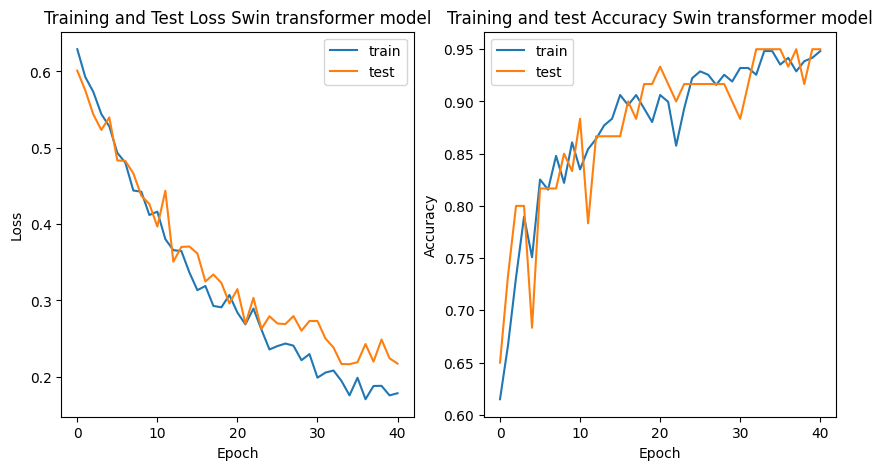

In [ ]:
# Plot the validation and training loss and accuracy values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_val_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss Swin transformer model')
ax[0].legend()
ax[1].plot(train_val_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy Swin transformer model')
ax[1].legend()
plt.show()

## Test performance Swin transformer model

In [ ]:
# load in testset
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
model.eval()
test_loss = 0.0
y_true = []
y_pred = []
Y_pred_prob = []

with torch.no_grad():
   for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred_prop = torch.sigmoid(output)
          pred = torch.round(torch.sigmoid(output))

          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())
          Y_pred_prob.extend(pred_prop.reshape(-1).tolist())

test_loss /= len(test_loader.sampler)
test_accuracy = accuracy_score(y_true,y_pred)

# get the specificity, sensitivity and g-mean
cm = confusion_matrix(y_true, y_pred)

# Extract the elements of the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

g_mean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


print()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, Y_pred_prob)

# Print the evaluation metrics
print('Test_loss:', test_loss)
print('Accuracy:', test_accuracy)
print()

print('Specificity:', specificity)
print('Sensitivity:', sensitivity)
print('g_mean:', g_mean)
print()

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))


Test_loss: 0.2173265626033147
Accuracy: 0.95

Specificity: 0.9444444444444444
Sensitivity: 0.9523809523809523
g_mean: 0.9484043965898193

Precision: 0.975609756097561
Recall: 0.9523809523809523
F1-score: 0.963855421686747
F1_score_macro: 0.9413871703028329
AUC-ROC: 0.9788359788359788

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92        18
         1.0       0.98      0.95      0.96        42

    accuracy                           0.95        60
   macro avg       0.94      0.95      0.94        60
weighted avg       0.95      0.95      0.95        60



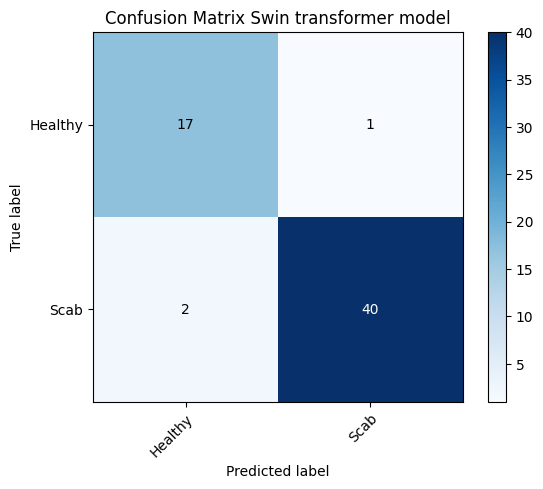

In [ ]:
import matplotlib.pyplot as plt

# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix Swin transformer model")
plt.show()